In [6]:
import rasterio
from rasterio import plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import math
import seaborn as sns
from typing import List, Dict
from zipfile import ZipFile
from collections import Counter

from ml_commons import *

sns.set_theme()

First label states individually in label-analysis notebook!
Then perform analysis on aggregated data here.

In [2]:
target_states = ['California', 'Montana', 'Washington', 'Florida', 'Texas']

cloud_cover_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [3]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset_16km_800')
state_dirs = pd.DataFrame(pd.Series(target_states, name='state'))
state_dirs['target']    = state_dirs['state'].apply(lambda state: os.path.join(data_dir, 'queries', state))
state_dirs['features']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'features'))
state_dirs['preprocessing']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'preprocessing'))
state_dirs['labels']  = state_dirs['preprocessing'].apply(lambda preprocessing_dir: os.path.join(preprocessing_dir, 'labels.csv'))
state_dirs.set_index('state', inplace=True)
for dir in state_dirs['features'].to_list() + state_dirs['preprocessing'].to_list():
    os.makedirs(dir, exist_ok=True)
state_dirs

,target,features,preprocessing,labels
state,,,,
California,data\queries\California,data\queries\California\features,data\queries\California\preprocessing,data\queries\California\preprocessing\labels.csv
Montana,data\queries\Montana,data\queries\Montana\features,data\queries\Montana\preprocessing,data\queries\Montana\preprocessing\labels.csv
Washington,data\queries\Washington,data\queries\Washington\features,data\queries\Washington\preprocessing,data\queries\Washington\preprocessing\labels.csv
Florida,data\queries\Florida,data\queries\Florida\features,data\queries\Florida\preprocessing,data\queries\Florida\preprocessing\labels.csv
Texas,data\queries\Texas,data\queries\Texas\features,data\queries\Texas\preprocessing,data\queries\Texas\preprocessing\labels.csv


In [4]:
labels: pd.DataFrame = pd.concat([pd.read_csv(state_dirs.loc[state, 'labels'], index_col=0) for state in target_states], ignore_index=True)
labels

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,BIH,00065e39-660f-4b17-a4ff-d528b87cef65,8.149600,CLR,CLR
1,MMH,00065e39-660f-4b17-a4ff-d528b87cef65,7.149600,CLR,CLR
2,JAQ,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
3,MCC,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
4,MHR,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
...,...,...,...,...,...
12744,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,FEW
12745,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,FEW
12746,ORG,ffd7c508-0a7d-4185-9ce8-511fc421d012,4.149600,SCT,BKN
12747,11R,fff52610-ce95-4c6b-9ebc-5d6912f0ff3d,8.316267,OVC,BKN


<Axes: title={'center': 'METAR label frequencies'}>

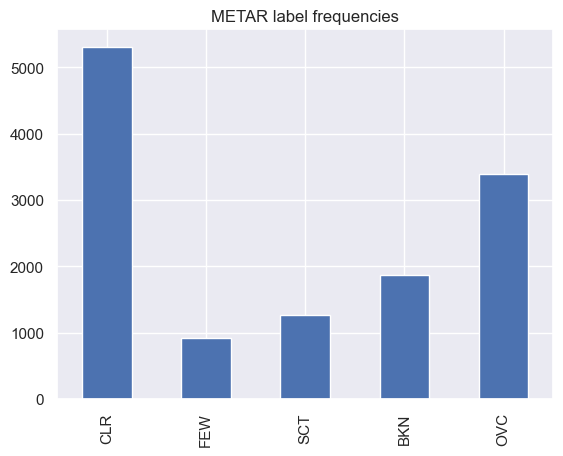

In [25]:
labels['max cloud cover'].value_counts().loc[cloud_cover_order].plot(kind='bar', title='METAR label frequencies')

<Axes: title={'center': 'Manual label frequencies'}>

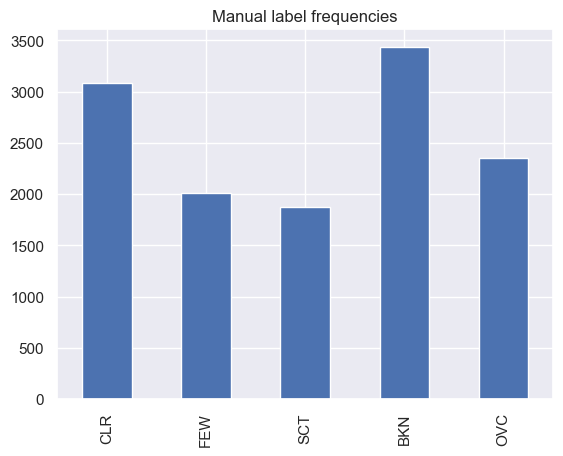

In [26]:
labels['true cloud cover'].value_counts().loc[cloud_cover_order].plot(kind='bar', title='Manual label frequencies')

In [5]:
labels_to_analyze = labels[~labels['true cloud cover'].isna()].copy()
labels_to_analyze

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,BIH,00065e39-660f-4b17-a4ff-d528b87cef65,8.149600,CLR,CLR
1,MMH,00065e39-660f-4b17-a4ff-d528b87cef65,7.149600,CLR,CLR
2,JAQ,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
3,MCC,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
4,MHR,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
...,...,...,...,...,...
12744,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,FEW
12745,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,FEW
12746,ORG,ffd7c508-0a7d-4185-9ce8-511fc421d012,4.149600,SCT,BKN
12747,11R,fff52610-ce95-4c6b-9ebc-5d6912f0ff3d,8.316267,OVC,BKN


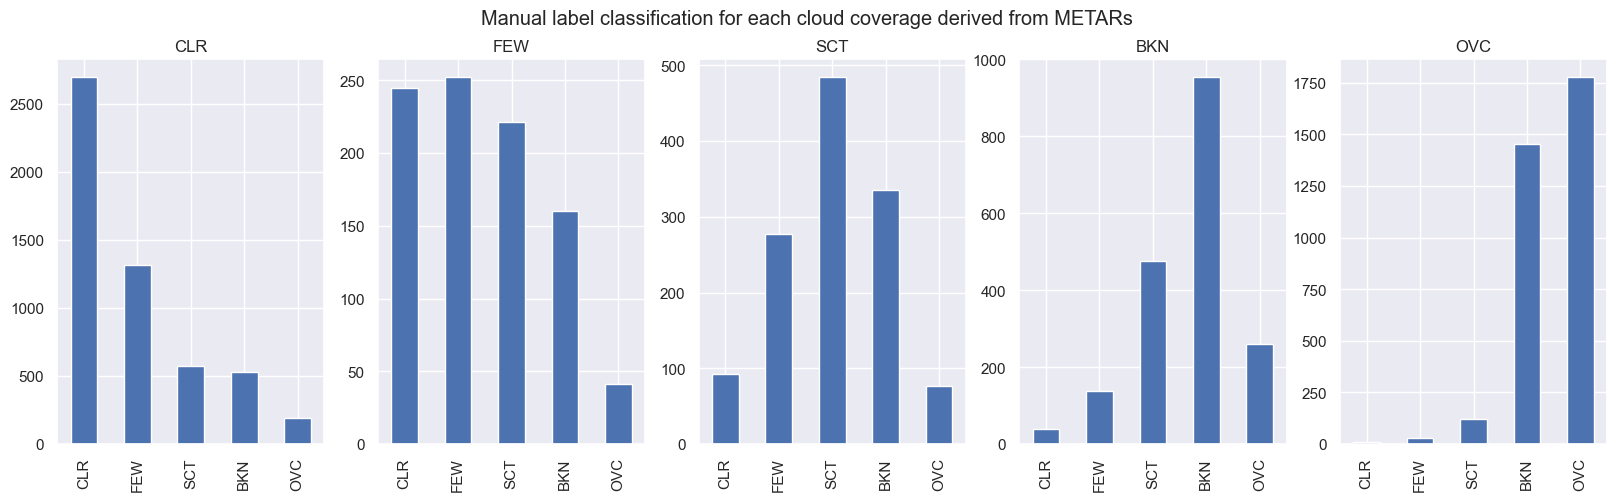

In [185]:
from collections import Counter

cc_counts = {}
fig, axs = plt.subplots(figsize=(4 * len(cloud_cover_order), 5), ncols=len(cloud_cover_order))
fig.suptitle('Manual label classification for each cloud coverage derived from METARs')
for i, cc in enumerate(cloud_cover_order):
    ax: plt.Axes = axs[i]
    counted_labels = pd.Series(Counter(labels_to_analyze[labels_to_analyze['max cloud cover'] == cc]['true cloud cover']))
    for cc_ in cloud_cover_order:
        if cc_ not in counted_labels:
            counted_labels[cc_] = 0
    counted_labels = counted_labels.loc[cloud_cover_order]
    counted_labels.plot.bar(ax=ax, title=cc)
    cc_counts[cc] = counted_labels

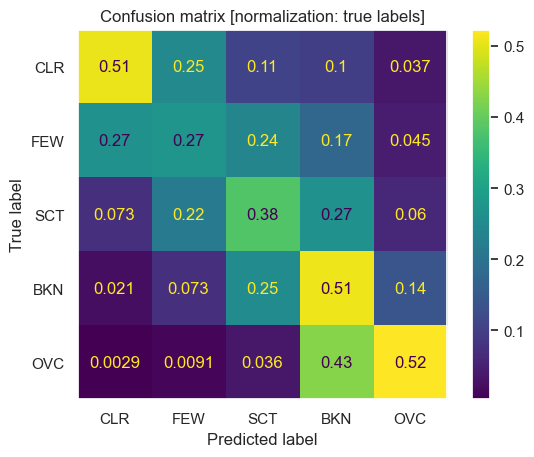

In [186]:
# compute the confusion matrix
from enum import Enum
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

class ConfusionMatrixNormalization(str, Enum):
    ALL_SAMPLES = 'all',
    TRUE_LABELS = 'true',
    PREDICTED_LABELS = 'pred'

normalization = ConfusionMatrixNormalization.TRUE_LABELS
normalization_mode = None
title = 'Confusion matrix'
if normalization is not None:
    normalization_mode = normalization.value
    title += ' [normalization: ' + normalization.name.lower().replace('_', ' ') + ']'
# set the model to evaluation mode

cm = confusion_matrix(y_true=labels_to_analyze['max cloud cover'].apply(lambda x: class_dict[x]),
                      y_pred=labels_to_analyze['true cloud cover'].apply(lambda x: class_dict[x]),
                      labels=range(len(cloud_cover_order)), normalize=normalization_mode)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cloud_cover_order)
disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.title(title)
plt.show()

cm = pd.DataFrame(cm, columns=cloud_cover_order, index=cloud_cover_order)

In [187]:
cm

,CLR,FEW,SCT,BKN,OVC
CLR,0.508014,0.247973,0.107486,0.099943,0.036583
FEW,0.266594,0.274211,0.240479,0.174102,0.044614
SCT,0.073460,0.218799,0.382306,0.265403,0.060032
BKN,0.021425,0.073380,0.254954,0.510445,0.139796
OVC,0.002946,0.009134,0.035946,0.428698,0.523276


In [188]:
def direct_neighbor_accumulation(data:pd.DataFrame) -> pd.DataFrame:
    result = []
    for i, cc in enumerate(cloud_cover_order):
        local_result = {'cloud cover': cc}
        cc_sum = data.loc[cc, cc]
        if i > 0:
            cc_sum += data.loc[cc, cloud_cover_order[i - 1]]
        if i < len(cloud_cover_order) - 1:
            cc_sum += data.loc[cc, cloud_cover_order[i + 1]]
        local_result['value'] = cc_sum
        result += [local_result]
    result = pd.DataFrame(result)
    result.set_index('cloud cover', inplace=True)
    return result

cc_neighbor_acc = direct_neighbor_accumulation(cm)
cc_neighbor_acc

,value
cloud cover,
CLR,0.755987
FEW,0.781284
SCT,0.866509
BKN,0.905196
OVC,0.951974


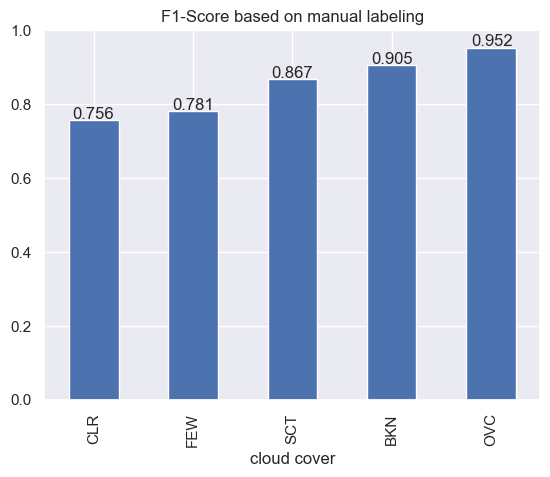

In [189]:
ax = cc_neighbor_acc.plot.bar(legend=False, title='F1-Score based on manual labeling')
ax.set_ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() * 1.005 + 0.03, p.get_height() * 1.005))

In [190]:
mislabeled = labels_to_analyze['max cloud cover'] != labels_to_analyze['true cloud cover']

In [191]:
labels_to_analyze['mismatch intensity'] = labels_to_analyze.apply(lambda row: class_dict[row['max cloud cover']] - class_dict[row['true cloud cover']], axis='columns')
labels_to_analyze['mismatch intensity']

0        0
1        0
2        0
3        0
4        0
        ..
12744   -1
12745   -1
12746   -1
12747    1
12748    1
Name: mismatch intensity, Length: 12749, dtype: int64

array([[<Axes: title={'center': 'BKN'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'CLR'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'FEW'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'OVC'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'SCT'}, xlabel='mismatch intensity'>]],
      dtype=object)

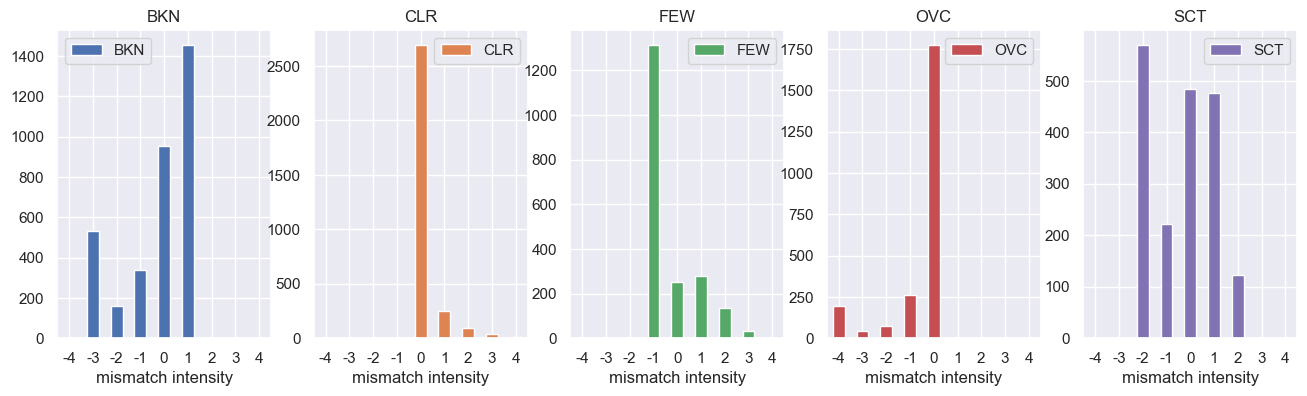

In [192]:
labels_to_analyze.groupby(['true cloud cover', 'mismatch intensity'])['max cloud cover'].count().loc[cloud_cover_order].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(16, 4), layout=(1, 5))

In [193]:
labels_to_analyze[mislabeled].groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order]

max cloud cover
CLR    2609
FEW     667
SCT     782
BKN     914
OVC    1618
Name: true cloud cover, dtype: int64

<Axes: title={'center': 'Frequency of mislabeling based on METAR labels'}, xlabel='max cloud cover'>

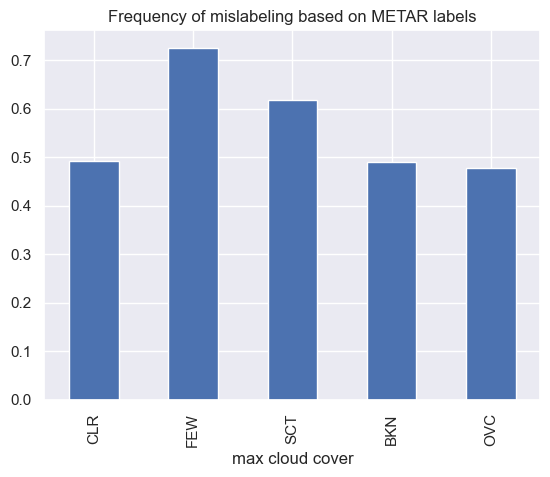

In [194]:
(labels_to_analyze[mislabeled].groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order] / labels_to_analyze.groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order]).plot.bar(title='Frequency of mislabeling based on METAR labels')

In [195]:
hard_mislabeled = labels_to_analyze['mismatch intensity'].abs() > 1

Text(0.5, 1.0, 'Time difference between satellite image and METAR observation')

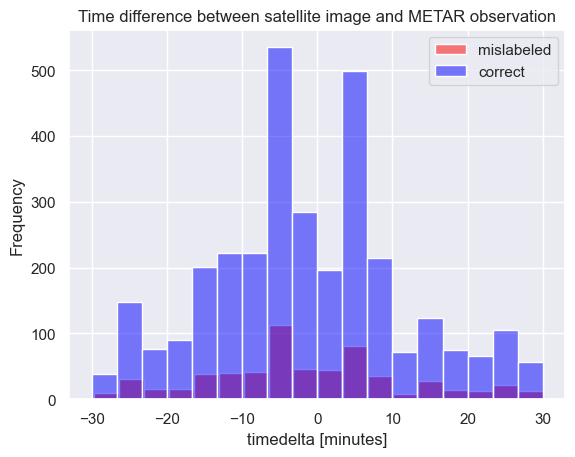

In [201]:
fig, ax = plt.subplots()
plot_bins = 18
sns.histplot(labels_to_analyze[hard_mislabeled]['timedelta [minutes]'], bins=plot_bins, ax=ax, alpha=0.5, color='red', label='mislabeled', stat='frequency')
sns.histplot(labels_to_analyze[~hard_mislabeled]['timedelta [minutes]'], bins=plot_bins, ax=ax, alpha=0.5, color='blue', label='correct', stat='frequency')
# labels_to_analyze[hard_mislabeled]['timedelta [minutes]'].plot.hist(bins=plot_bins, ax=ax, alpha=0.5, color='red', label='mislabeled')
# labels_to_analyze[~hard_mislabeled]['timedelta [minutes]'].plot.hist(bins=plot_bins, ax=ax, alpha=0.5, color='blue', label='correct')
ax.set_xlabel('timedelta [minutes]')
ax.legend()
ax.set_title('Time difference between satellite image and METAR observation')

Text(0.5, 1.0, 'Time Differences of Correct Data')

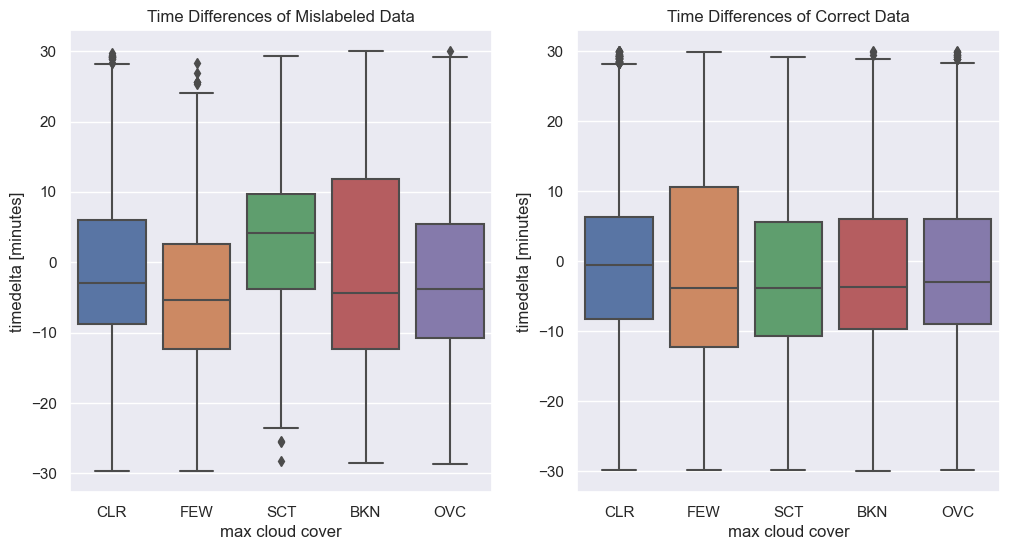

In [158]:
fig, axs = plt.subplots(figsize=(12,6), ncols=2)
sns.boxplot(labels_to_analyze[hard_mislabeled], x='max cloud cover', y='timedelta [minutes]', order=cloud_cover_order, ax=axs[0])
axs[0].set_title('Time Differences of Mislabeled Data')
sns.boxplot(labels_to_analyze[~hard_mislabeled], x='max cloud cover', y='timedelta [minutes]', order=cloud_cover_order, ax=axs[1])
axs[1].set_title('Time Differences of Correct Data')

In [159]:
mislabels_by_station = labels_to_analyze[hard_mislabeled].groupby('station')['max cloud cover'].count()
labels_by_station = labels_to_analyze.groupby('station')['max cloud cover'].count()

In [160]:
mislabels_by_station_rel = []
for i, count in mislabels_by_station.items():
    mislabels_by_station_rel += [{'station': i, 'frequency': count / labels_by_station.loc[i]}]
mislabels_by_station_rel = pd.DataFrame(mislabels_by_station_rel)
mislabels_by_station_rel.set_index('station', inplace=True)
mislabels_by_station_rel.sort_values('frequency', inplace=True)
mislabels_by_station_rel

,frequency
station,
RND,0.027027
HWD,0.027778
SFF,0.028571
CRP,0.029412
SKA,0.029412
...,...
LUV,0.371429
GTF,0.382353
PO1,0.388889


Text(0.5, 1.0, 'Mislabeling Frequency')

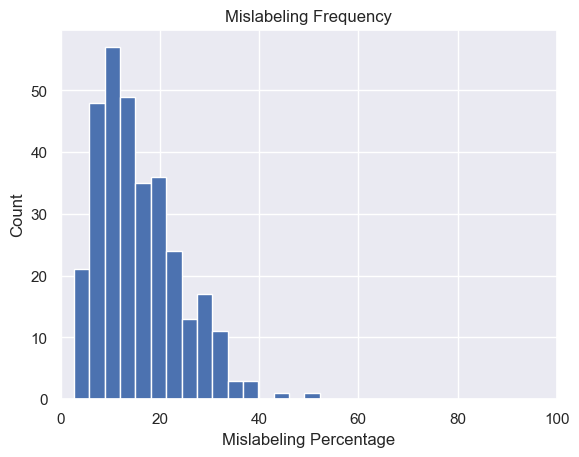

In [205]:
fig, ax = plt.subplots()
# (mislabels_by_station_rel * 100).plot.hist(bins=16, title='Mislabeling Frequency', legend=False)
sns.histplot(mislabels_by_station_rel * 100, bins=16, legend=False, color='blue', alpha=1)
ax.set_xlabel('Mislabeling Percentage')
ax.set_xlim(0, 100)
ax.set_title('Mislabeling Frequency')

<Axes: xlabel='station'>

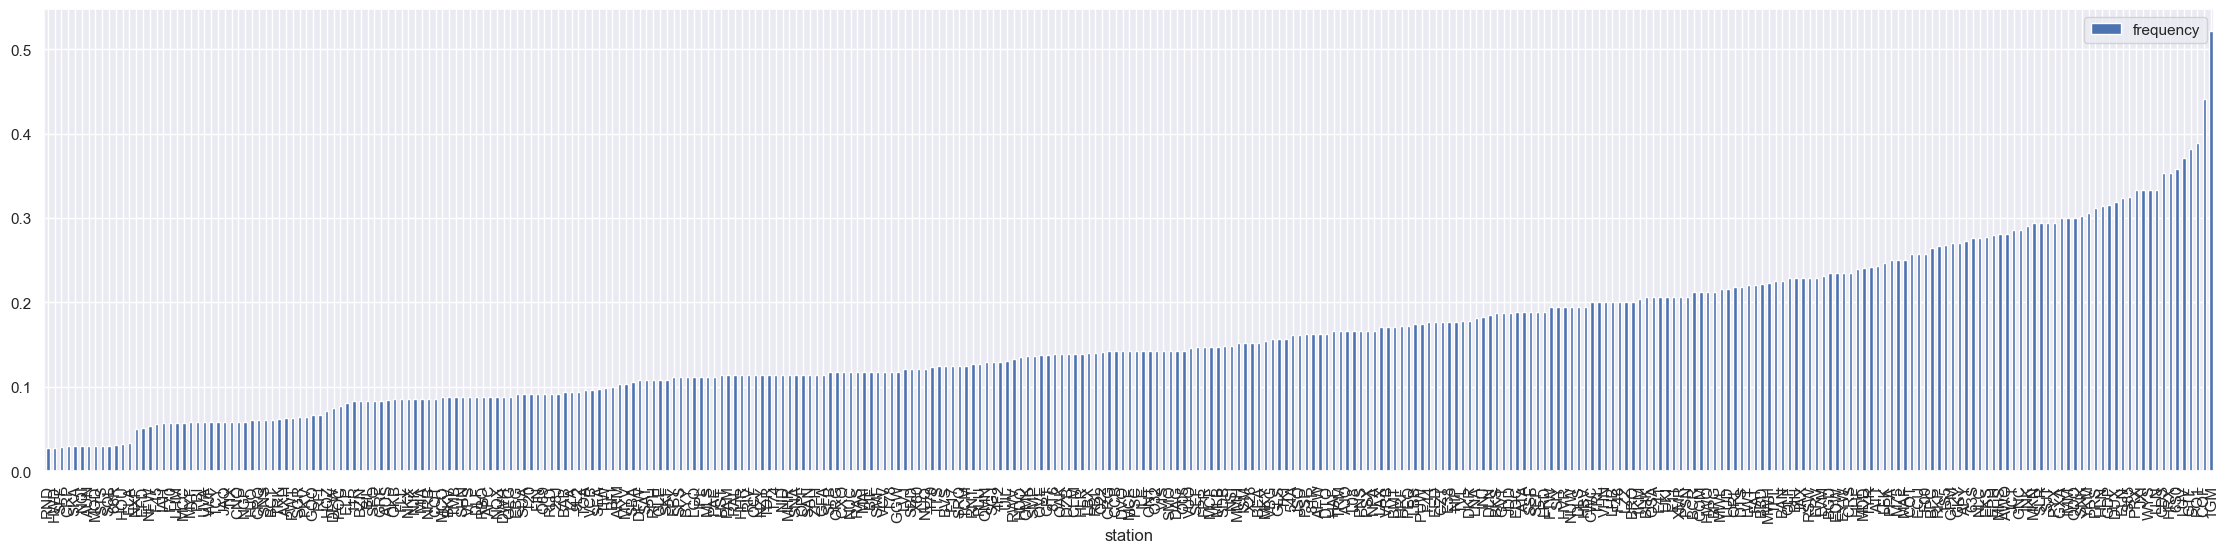

In [162]:
fig, ax = plt.subplots(figsize=(28, 6))
mislabels_by_station_rel.plot.bar(ax=ax)

In [163]:
import shapely

station_metadata = []
for state in os.listdir(os.path.join('data', 'queries')):
    station_metadata += [pd.read_csv(os.path.join('data', 'queries', state, 'preprocessing', 'station_metadata.csv'))]
station_metadata = pd.concat(station_metadata)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, crs='EPSG:4326')
station_metadata.set_index('id', inplace=True)
station_metadata.head()

,geometry,name,plot_name,network,latitude,longitude,elevation,index_right,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,154,USA,United States of America,North America,0.0
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,154,USA,United States of America,North America,0.0
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,154,USA,United States of America,North America,0.0
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,154,USA,United States of America,North America,0.0
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,154,USA,United States of America,North America,0.0


In [164]:
station_metadata['mislabeled'] = np.nan

In [165]:
for station, mislabeled in mislabels_by_station_rel['frequency'].items():
    station_metadata.loc[station, 'mislabeled'] = mislabeled

In [166]:
station_metadata = gpd.GeoDataFrame(station_metadata[~station_metadata['mislabeled'].isna()])

In [167]:
usa_states = gpd.GeoDataFrame.from_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

(-130.0, -65.0, 22.0, 50.0)

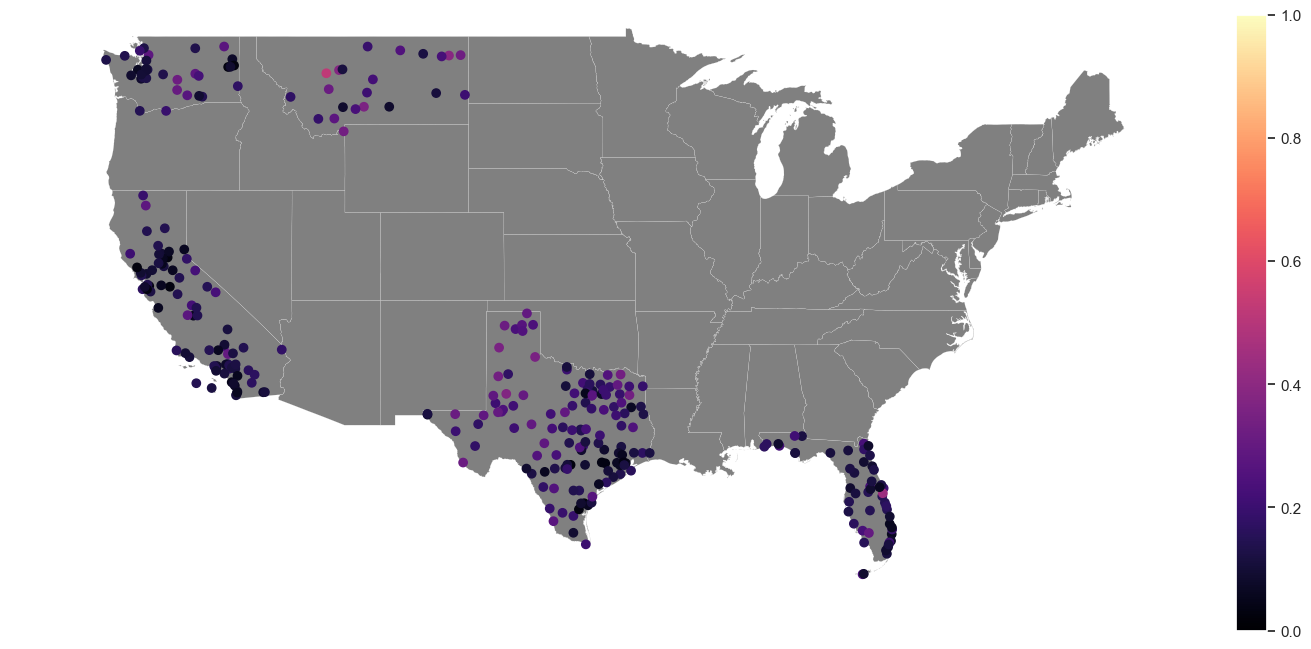

In [168]:
assert isinstance(station_metadata, gpd.GeoDataFrame)
fig, ax = plt.subplots(figsize=(20, 8))
usa_states.plot(ax=ax, facecolor='gray', linewidth=0.1)
station_metadata.plot('mislabeled', cmap='magma', vmin=0, vmax=1, ax=ax, legend=True)
ax.set_xlim(-130, -65)
ax.set_ylim(22, 50)
ax.axis(False)

In [169]:
networks = station_metadata['network'].unique()

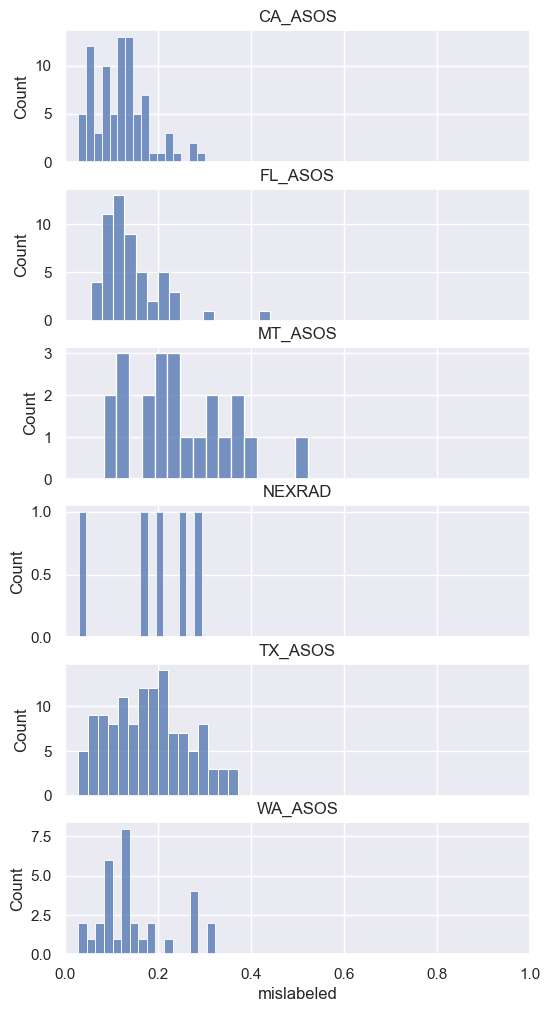

In [170]:
multi_network = len(networks) > 1
fig, axs = plt.subplots(nrows=len(networks), sharex=True, figsize=(6, 12) if multi_network else (6, 6))
for i, network in enumerate(networks):
    if multi_network:
        ax: plt.Axes = axs[i]
    else:
        ax: plt.Axes = axs
    ax.set_xlim(0, 1)
    ax.set_title(network)
    sns.histplot(station_metadata[station_metadata['network'] == network]['mislabeled'], ax=ax, bins=16)

In [171]:
labels_to_analyze['true cloud cover']

0        CLR
1        CLR
2        CLR
3        CLR
4        CLR
        ... 
12744    FEW
12745    FEW
12746    BKN
12747    BKN
12748    BKN
Name: true cloud cover, Length: 12749, dtype: object

In [172]:
training_labels_path = os.path.join(dataset_dir, 'training_labels.csv')
validation_labels_path = os.path.join(dataset_dir, 'validation_labels.csv')
test_labels_path = os.path.join(dataset_dir, 'test_labels.csv')
training_labels = pd.read_csv(training_labels_path, index_col=0)
validation_labels = pd.read_csv(validation_labels_path, index_col=0)
test_labels = pd.read_csv(test_labels_path, index_col=0)
training_labels.reset_index(drop=True, inplace=True)
validation_labels.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

In [173]:
training_labels

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,MCC,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,NaN
1,MHR,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,NaN
2,SAC,004885ef-ae75-4aca-917a-4218687d4536,3.682933,CLR,NaN
3,SMF,004885ef-ae75-4aca-917a-4218687d4536,3.682933,FEW,NaN
4,CRQ,00cb0f2f-92d9-4544-8be8-ec1ba851a7d4,19.682917,OVC,NaN
...,...,...,...,...,...
10189,TPL,ffc6975c-dafc-4219-983a-e181e6d07e32,-9.517067,CLR,NaN
10190,LBB,ffd2f23c-d37f-406f-a730-2e7597690168,23.982917,BKN,NaN
10191,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,NaN
10192,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,NaN


In [174]:
training_labels = labels[labels['station'].isin(training_labels['station'])].reset_index(drop=True)
validation_labels = labels[labels['station'].isin(validation_labels['station'])].reset_index(drop=True)
test_labels = labels[labels['station'].isin(test_labels['station'])].reset_index(drop=True)

In [175]:
training_labels

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,MCC,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
1,MHR,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
2,SAC,004885ef-ae75-4aca-917a-4218687d4536,3.682933,CLR,CLR
3,SMF,004885ef-ae75-4aca-917a-4218687d4536,3.682933,FEW,CLR
4,CRQ,00cb0f2f-92d9-4544-8be8-ec1ba851a7d4,19.682917,OVC,BKN
...,...,...,...,...,...
10189,TPL,ffc6975c-dafc-4219-983a-e181e6d07e32,-9.517067,CLR,OVC
10190,LBB,ffd2f23c-d37f-406f-a730-2e7597690168,23.982917,BKN,BKN
10191,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,FEW
10192,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,FEW


In [176]:
write_to_dataset = True
if write_to_dataset:
    training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index_label='index')
    validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index_label='index')
    test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index_label='index')